In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load .mat data
data = scipy.io.loadmat(r'C:\Users\18216\Desktop\UC_train_test_case57.mat')

X_train = torch.tensor(data['X_train'], dtype=torch.float32)  # shape: [N, N_d, 24]
Y_train = torch.tensor(data['Y_train'], dtype=torch.float32)  # shape: [N, N_g, 24]
X_test = torch.tensor(data['X_test'], dtype=torch.float32)
Y_test = torch.tensor(data['Y_test'], dtype=torch.float32)
        
def calculate_violation_rate(X, Y, tolerance=5e-4):
    """
    Calculate power balance violation rate for raw UC data.
    
    Args:
        X: Demand data [num_buses, num_hours, num_days]
        Y: Generation data [num_gens, num_hours, num_days]
        tolerance: Allowed imbalance threshold (MW)
    
    Returns:
        violation_rate: Percentage of timesteps with imbalance > tolerance
    """
    total_demand = X.sum(axis=0)  # Sum across buses [hours, days]
    total_generation = Y.sum(axis=0)  # Sum across gens [hours, days]
    imbalance = np.abs(total_generation - total_demand)
    
    violations = (imbalance > tolerance).sum()
    total_timesteps = X.shape[1] * X.shape[2]
    
    return violations / total_timesteps * 100  # Percentage

violation_rate = calculate_violation_rate(X_train, Y_train)
print(f"Violation rate: {violation_rate:.2f}%")

# Experiments show that when tolerance reduces to 1e-6, the violation rate will surge up to 28.76%

Violation rate: 0.00%


In [77]:
print("The X_train shape:", X_train.shape)

def remove_zero_demand_buses(X_reshaped):
    """
    Args:
        X_reshaped: Demand data shaped [num_buses, num_samples] (9×19200 or 9×4800)
    Returns:
        X_filtered: Demand data with zero-demand buses removed
        kept_bus_indices: Indices of buses with non-zero demand
    """
    # Find buses that have ANY NON-zero demand
    non_zero_mask = (X_reshaped != 0).any(axis=1)
    kept_bus_indices = torch.where(non_zero_mask)[0]
    
    # Filter the data
    X_filtered = X_reshaped[non_zero_mask, :]
    
    return X_filtered

# Reshape and filter training data
X_train_reshaped = X_train.reshape(X_train.size(0), -1)  
X_train_filtered = remove_zero_demand_buses(X_train_reshaped)

# Reshape and filter test data (using same bus indices)
X_test_reshaped = X_test.reshape(X_test.size(0), -1)  
X_test_filtered = remove_zero_demand_buses(X_test_reshaped)

print(f"Filtered shape: {X_train_filtered.shape}") 
print("The first few rows of X_train_filtered:", X_train_filtered[:])
print("The first few rows of X_test_filtered:", X_test_filtered[:])

The X_train shape: torch.Size([57, 24, 800])
Filtered shape: torch.Size([42, 19200])
The first few rows of X_train_filtered: tensor([[42.3235, 49.3062, 45.8781,  ..., 46.8794, 53.3829, 49.9865],
        [ 2.5193,  2.4668,  2.7058,  ...,  2.7501,  2.9944,  2.8524],
        [34.6924, 33.4840, 36.9411,  ..., 38.2551, 34.7985, 35.4912],
        ...,
        [ 6.1192,  5.8591,  5.1748,  ...,  6.2111,  5.9621,  5.9661],
        [ 5.7502,  6.5784,  5.6717,  ...,  7.3263,  6.5625,  7.2501],
        [ 5.2930,  5.4197,  5.5924,  ...,  6.5870,  5.6937,  6.7437]])
The first few rows of X_test_filtered: tensor([[41.6780, 47.9546, 46.7111,  ..., 53.5922, 46.5998, 47.0131],
        [ 2.5874,  2.6244,  2.4657,  ...,  3.0048,  2.9501,  2.8749],
        [31.2546, 37.1420, 33.7493,  ..., 41.5462, 40.3257, 37.5322],
        ...,
        [ 6.1081,  6.0048,  5.1598,  ...,  6.3359,  6.9115,  6.4456],
        [ 6.0732,  6.6578,  6.0286,  ...,  7.4747,  7.3677,  6.4256],
        [ 5.8541,  5.3025,  5.6531,  ..

In [78]:
# Reshape the filtered X_train and X_test
N_demand = X_train_filtered.shape[0]
X_train = X_train_filtered.reshape(N_demand, 24, 800)
X_test = X_test_filtered.reshape(N_demand, 24, 200)
print("The shape of X_test:", X_test.shape)

The shape of X_test: torch.Size([42, 24, 200])


In [79]:
# Data normalization
def normalize(X):
    """
    Args:
        X: Input tensor [num_demands, num_hours, num_days]
    Returns:
        X_norm: Normalized tensor [num_demands, num_hours, num_days]
        means: Per-bus means [num_demands]
        stds: Per-bus stds [num_demands]
    """
    # Compute stats across ALL hours and days
    means = X.mean(dim=(1, 2))  
    stds = X.std(dim=(1, 2))    
    stds[stds < 1e-6] = 1e-6    # Avoid division by zero
    
    # Normalize
    X_norm = (X - means.view(-1, 1, 1)) / stds.view(-1, 1, 1)
    return X_norm, means, stds

# Train set normalization
X_train_norm, X_train_means, X_train_stds = normalize(X_train)
X_test_norm, X_test_means, X_test_stds = normalize(X_test)

print("The X_test_norm shape:", X_test_norm.shape)
first_two_days = X_train_norm[:, :, :2]  

# Print first day's data for all buses
print("First day generation:")
print(first_two_days[:, :, 0])

print("Total X_train and X_test means:", X_train_means.sum(), X_test_means.sum())
imbalance_tolerance = 0.01 * ((X_train_means.sum() + X_test_means.sum())/2)
print("The imbalance tolerance for case57 is:", imbalance_tolerance)

The X_test_norm shape: torch.Size([42, 24, 200])
First day generation:
tensor([[-1.7617, -1.5147, -1.6334,  ..., -0.2978, -0.4257, -1.0710],
        [-1.2255, -0.9552, -1.0852,  ...,  0.3765,  0.2365, -0.4697],
        [-1.1592, -0.8875, -1.0181,  ...,  0.4509,  0.3102, -0.3995],
        ...,
        [-0.7424, -0.4544, -0.5929,  ...,  0.9641,  0.8151,  0.0628],
        [-1.8573, -1.6140, -1.7309,  ..., -0.4156, -0.5415, -1.1770],
        [-1.5731, -1.3192, -1.4412,  ..., -0.0686, -0.2000, -0.8632]])
Total X_train and X_test means: tensor(1251.8372) tensor(1250.7719)
The imbalance tolerance for case57 is: tensor(12.5130)


In [80]:
# Reshape datasets to [800*24,num_demand] for training and [200*24,num_demand] for test, each row stands for a time step
X_train_norm = X_train_norm.reshape(-1, X_train.size(0))
X_test_norm = X_test_norm.reshape(-1, X_test.size(0))

print("Now the X_train_norm shape is:", X_train_norm.shape)
print("The input size for NN is:", X_train_norm.size(1))

Now the X_train_norm shape is: torch.Size([19200, 42])
The input size for NN is: 42


In [81]:
# Apply min-max scale for Y_train and Y_test
N_gen = Y_train.size(0)
P_max = torch.tensor([575.88,100,140,100,550,100,410], dtype=torch.float32)  
P_min = torch.tensor([0,0,0,0,0,0,0], dtype=torch.float32)      

# note the use of permute().reshape()
Y_train_flat = Y_train.permute(1, 2, 0).reshape(-1, N_gen)  # [hours*days, gens]
Y_test_flat = Y_test.permute(1, 2, 0).reshape(-1, N_gen)     # [hours*days, gens]

# Proper min-max scaling
Y_train_scaled = (Y_train_flat - P_min) / (P_max - P_min)
Y_test_scaled = (Y_test_flat - P_min) / (P_max - P_min)

# Verify
print("Y_train_scaled range (min):", Y_train_scaled.min(dim=0).values)
print("Y_train_scaled range (max):", Y_train_scaled.max(dim=0).values)
# Should output ~[0, 1] for each generator
print("Y_test_scaled range (min):", Y_test_scaled.min(dim=0).values)

print("Y_train_scaled shape:", Y_train_scaled.shape)
print("Y_test_scaled shape:", Y_test_scaled.shape)

Y_train_scaled range (min): tensor([0.2258, 0.0857, 0.2882, 0.0857, 0.8252, 0.0857, 0.7626])
Y_train_scaled range (max): tensor([0.3232, 1.0000, 0.4126, 1.0000, 1.0000, 1.0000, 1.0000])
Y_test_scaled range (min): tensor([0.2264, 0.1146, 0.2890, 0.1146, 0.8276, 0.1146, 0.7648])
Y_train_scaled shape: torch.Size([19200, 7])
Y_test_scaled shape: torch.Size([4800, 7])


In [82]:
def power_balance_penalty(pred_gen, demand, tolerance):
    """
    New penalty function:
    - Returns 0 if imbalance ≤ tolerance (no penalty)
    - Returns (imbalance - tolerance) if imbalance > tolerance (linear penalty)
    """
    imbalance = torch.abs(demand.sum(dim=1) - pred_gen.sum(dim=1)).abs()  # [batch_size]
    violation = torch.clamp_min(imbalance - tolerance, 0)  # ReLU-like
    return violation.mean()  # Mean across batch

In [83]:
def project_to_feasible(pred_normalized, demand, P_min, P_max, X_means, X_stds, imbalance_tolerance):
    """
    Forces power balance while respecting generator limits.
    Only projects values that violate the power imbalance tolerance.
    """
    pred_MW = pred_normalized * (P_max - P_min) + P_min
    demand_MW = demand * X_stds + X_means
    total_demand = demand_MW.sum(dim=1, keepdim=True)
    
    # Case 1: If generation is zero (edge case)
    gen_sum = pred_MW.sum(dim=1, keepdim=True)
    pred_MW[gen_sum.squeeze() < 1e-6] = total_demand[gen_sum.squeeze() < 1e-6] / pred_MW.shape[1]
    
    # Calculate current imbalance
    current_imbalance = torch.abs(pred_MW.sum(dim=1, keepdim=True) - total_demand)
    
    # Only project samples where imbalance exceeds tolerance
    needs_projection = current_imbalance > imbalance_tolerance
    
    # Initialize feasible_gen with original values
    feasible_gen = pred_MW.clone()
    
    # Apply projection only where needed
    feasible_gen[needs_projection.squeeze()] = (
        pred_MW[needs_projection.squeeze()] * 
        (total_demand[needs_projection.squeeze()] / 
         (pred_MW[needs_projection.squeeze()].sum(dim=1, keepdim=True) + 1e-6))
    )
    
    return feasible_gen

In [84]:
#Hyperparameters

input_size = X_train_norm.size(1)
output_size = Y_train_scaled.size(1)
hidden_size_1 = 256   
hidden_size_2 = 128
hidden_size_3 = 64
num_epochs = 800        
batch_size = 256      
learning_rate = 1e-3   

a = 3.0  # MSE weight 
b = 0.05  


class Load2GenNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Load2GenNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.BatchNorm1d(hidden_size_3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_3, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
model = Load2GenNN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,           # Start with higher LR than Adam (typical range: 0.01-0.1)
    momentum=0.98,      # Critical for escaping local minima (range: 0.8-0.99)
    weight_decay=1e-4, # Stronger L2 regularization helps with momentum
    nesterov=True      # Nesterov accelerated gradient (recommended)
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

train_dataset = TensorDataset(X_train_norm, Y_train_scaled)
test_dataset = TensorDataset(X_test_norm, Y_test_scaled)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [85]:
train_losses = []
test_losses = []
train_penalties = []  
test_penalties = [] 
train_mses = []
test_mses = []
raw_feasibility_rates = []
projected_feasibility_rates = []

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train()
    epoch_train_loss = 0.0
    epoch_train_penalty = 0.0
    epoch_train_mse = 0.0
    
    for xb, yb in train_loader:
        # Forward pass
        pred = model(xb)
        mse_loss = criterion(pred, yb)
        real_pred = pred * (P_max - P_min) + P_min
        real_xb = xb * X_train_stds + X_train_means
        
        balance_penalty = power_balance_penalty(real_pred, real_xb, imbalance_tolerance)
        loss = a * mse_loss + b * balance_penalty
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  
        optimizer.step()
        
        # Track losses
        epoch_train_loss += loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_penalty += balance_penalty.item()
    
    # Store training metrics
    train_losses.append(epoch_train_loss / len(train_loader))
    train_penalties.append(epoch_train_penalty / len(train_loader))
    train_mses.append(epoch_train_mse/len(train_loader))
    # ==================== VALIDATION ====================
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_mse = 0.0
    epoch_test_penalty = 0.0
    epoch_raw_feasible = 0.0
    epoch_proj_feasible = 0.0
    all_preds = []
    all_imbalances = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            # Forward pass
            pred = model(xb)
            # all_preds.append(pred.cpu())
            
            mse_loss = criterion(pred, yb)
            real_pred = pred * (P_max - P_min) + P_min
            real_xb = xb * X_test_stds + X_test_means
            
            # Calculate metrics
            balance_penalty = power_balance_penalty(real_pred, real_xb, imbalance_tolerance)
            loss = a * mse_loss + b * balance_penalty
            
            epoch_test_loss += loss.item()
            epoch_test_mse += mse_loss.item()
            epoch_test_penalty += balance_penalty.item()
            
            # Feasibility checks
            raw_imbalance = torch.abs(real_xb.sum(dim=1) - real_pred.sum(dim=1))
            epoch_raw_feasible += (raw_imbalance <= imbalance_tolerance).float().mean().item()
            
            
            projected_pred = project_to_feasible(pred, xb, P_min, P_max, X_test_means, X_test_stds, imbalance_tolerance)
            all_preds.append(projected_pred.cpu())
            
            proj_imbalance = torch.abs(real_xb.sum(dim=1) - projected_pred.sum(dim=1))
            epoch_proj_feasible += (proj_imbalance <= imbalance_tolerance).float().mean().item()
            
            all_imbalances.append(proj_imbalance.cpu())
    
    # Store validation metrics
    test_loss = epoch_test_loss / len(test_loader)
    test_mse = epoch_test_mse / len(test_loader)
    test_penalty = epoch_test_penalty / len(test_loader)
    raw_feasibility = 100 * epoch_raw_feasible / len(test_loader)
    projected_feasibility = 100 * epoch_proj_feasible / len(test_loader)
    
    test_losses.append(test_loss)
    test_mses.append(test_mse)
    test_penalties.append(test_penalty)
    raw_feasibility_rates.append(raw_feasibility)
    projected_feasibility_rates.append(projected_feasibility)
    
    if epoch_test_mse <= 0.0358:
        a = 3.0
        b = 0.1
    if epoch_test_mse >= 0.0462:
        a = 5.0
        b = 0.05
        
    # Print every N epochs
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        max_imbalance = torch.cat(all_imbalances).max().item()
        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_loss:.4f}")
        print(f"MSE loss: {test_mse:.4f} | Penalty Loss: {test_penalty:.4f}")
        print(f"Raw Feasibility: {raw_feasibility:.2f}% | Projected: {projected_feasibility:.2f}%")
        # print(f"Max Projected Imbalance: {max_imbalance:.6f} MW")


Epoch 1:
Train Loss: 7.5423 | Test Loss: 2.8530
MSE loss: 0.1216 | Penalty Loss: 49.7631
Raw Feasibility: 10.22% | Projected: 100.00%

Epoch 11:
Train Loss: 0.6528 | Test Loss: 0.3343
MSE loss: 0.0537 | Penalty Loss: 1.3130
Raw Feasibility: 76.77% | Projected: 100.00%

Epoch 21:
Train Loss: 0.5071 | Test Loss: 0.2716
MSE loss: 0.0468 | Penalty Loss: 0.7548
Raw Feasibility: 87.21% | Projected: 100.00%

Epoch 31:
Train Loss: 0.4564 | Test Loss: 0.2427
MSE loss: 0.0460 | Penalty Loss: 0.2533
Raw Feasibility: 92.86% | Projected: 100.00%

Epoch 41:
Train Loss: 0.4417 | Test Loss: 0.2462
MSE loss: 0.0456 | Penalty Loss: 0.3653
Raw Feasibility: 91.10% | Projected: 100.00%

Epoch 51:
Train Loss: 0.4247 | Test Loss: 0.2343
MSE loss: 0.0454 | Penalty Loss: 0.1459
Raw Feasibility: 97.16% | Projected: 100.00%

Epoch 61:
Train Loss: 0.4069 | Test Loss: 0.2338
MSE loss: 0.0453 | Penalty Loss: 0.1492
Raw Feasibility: 96.59% | Projected: 100.00%

Epoch 71:
Train Loss: 0.4421 | Test Loss: 0.2555
MSE l


Epoch 611:
Train Loss: 0.3003 | Test Loss: 0.2259
MSE loss: 0.0450 | Penalty Loss: 0.0195
Raw Feasibility: 99.55% | Projected: 100.00%

Epoch 621:
Train Loss: 0.2963 | Test Loss: 0.2311
MSE loss: 0.0449 | Penalty Loss: 0.1340
Raw Feasibility: 97.04% | Projected: 100.00%

Epoch 631:
Train Loss: 0.2937 | Test Loss: 0.2272
MSE loss: 0.0449 | Penalty Loss: 0.0499
Raw Feasibility: 98.50% | Projected: 100.00%

Epoch 641:
Train Loss: 0.2853 | Test Loss: 0.2258
MSE loss: 0.0450 | Penalty Loss: 0.0125
Raw Feasibility: 99.73% | Projected: 100.00%

Epoch 651:
Train Loss: 0.2825 | Test Loss: 0.2267
MSE loss: 0.0449 | Penalty Loss: 0.0440
Raw Feasibility: 98.88% | Projected: 100.00%

Epoch 661:
Train Loss: 0.2903 | Test Loss: 0.2307
MSE loss: 0.0448 | Penalty Loss: 0.1381
Raw Feasibility: 96.49% | Projected: 100.00%

Epoch 671:
Train Loss: 0.2910 | Test Loss: 0.2258
MSE loss: 0.0449 | Penalty Loss: 0.0206
Raw Feasibility: 99.51% | Projected: 100.00%

Epoch 681:
Train Loss: 0.2934 | Test Loss: 0.22

In [86]:
def count_zero_predictions(all_preds):
    """
    Counts zero predictions (values < 1e-6) across all_preds.
    
    Args:
        all_preds: List of prediction tensors (normalized [0,1])
        
    Returns:
        int: Total count of zero values
    """
    return (torch.cat(all_preds, dim=0) < 0.0001).sum().item()

# Usage
zero_count = count_zero_predictions(all_preds)
print(f"Total zeros in predictions: {zero_count}")

Total zeros in predictions: 0


In [87]:
def analyze_hourly_ramp_violations(all_preds, P_min, P_max, min_ramp_limits_MW_per_hour, max_ramp_limits_MW_per_hour):
    """
    Analyze hourly ramp violations (1-hour time steps).
    
    Args:
        all_preds: List of normalized prediction tensors [batch_size, num_gens] ∈ [0,1]
        P_min/P_max: Generator limits [num_gens] (MW)
        min/max_ramp_limits_MW_per_hour: Ramp limits [num_gens] (MW/hour)
    
    Returns:
        Dict with:
        - 'max_violation': Maximum violation magnitude (MW)
        - 'worst_generator': Index of most violating generator
        - 'violation_rate': % of intervals with violations
        - 'per_gen_stats': DataFrame with per-generator statistics
    """
    # Convert to MW and concatenate
    preds_MW = torch.cat(all_preds, dim=0)  # [num_hours, num_gens]
    
    # Calculate hourly ramps
    deltas = torch.diff(preds_MW, dim=0)  # [num_hours-1, num_gens] (MW change/hour)
    
    # Check violations (absolute delta > limit)
    violations_to_min = deltas.abs() > min_ramp_limits_MW_per_hour  # Boolean mask
    violations_to_max = deltas.abs() > max_ramp_limits_MW_per_hour
    violation_magnitudes = (deltas.abs() - max_ramp_limits_MW_per_hour).clamp_min(0)
    
    # Aggregate statistics
    max_violation = violation_magnitudes.max().item()
    worst_generator = violation_magnitudes.max(dim=1)[0].argmax().item()
    
    # Per-generator stats
    import pandas as pd
    per_gen_stats = pd.DataFrame({
        'Generator': [f'G{i+1}' for i in range(len(min_ramp_limits_MW_per_hour))],
        'MinRampLimit_MW/h': min_ramp_limits_MW_per_hour.cpu().numpy(),
        'MaxRampLimit_MW/h': max_ramp_limits_MW_per_hour.cpu().numpy(),
        'Violation_to_minCount': violations_to_min.sum(dim=0).cpu().numpy(),
        'Violation_to_maxCount': violations_to_max.sum(dim=0).cpu().numpy(),
        'MaxViolation_MW': violation_magnitudes.max(dim=0)[0].cpu().numpy(),
        'AvgViolation_MW': violation_magnitudes.mean(dim=0).cpu().numpy()
    })
    
    return {
        'max_violation': max_violation,
        'worst_generator': worst_generator,
        'max_violation_rate': 100 * violations_to_min.float().mean().item(),
        'min_violation_rate': 100 * violations_to_max.float().mean().item(),
        'per_gen_stats': per_gen_stats,
        'total_hours': preds_MW.shape[0] - 1
    }

# Usage Example
min_ramp_limits = torch.full((N_gen,), 90.0) 
max_ramp_limits = torch.full((N_gen,), 114.0)
stats = analyze_hourly_ramp_violations(all_preds, P_min, P_max, min_ramp_limits, max_ramp_limits)

print(f"""
=== Hourly Ramp Violation Report ===
Max violation: {stats['max_violation']:.2f} MW
Worst generator: G{stats['worst_generator']+1}
Global maximum violation rate: {stats['max_violation_rate']:.2f}%
Global minimum violation rate: {stats['min_violation_rate']:.2f}%
Total hours analyzed: {stats['total_hours']}
""")
# print("\nPer-generator statistics:")
# print(stats['per_gen_stats'].to_markdown(index=False))


=== Hourly Ramp Violation Report ===
Max violation: 9.77 MW
Worst generator: G2738
Global maximum violation rate: 0.13%
Global minimum violation rate: 0.01%
Total hours analyzed: 4799



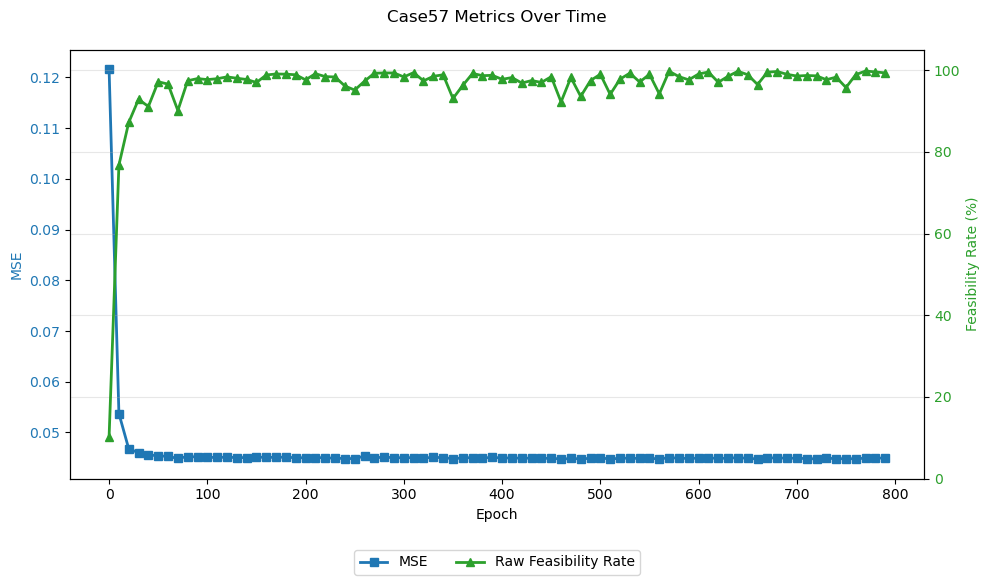

In [88]:
# Visualization of the validation
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these lists:
# test_losses = [...]         # List of loss values
# test_mses = [...]           # List of MSE values (100 values)
# raw_feasibility_rates = [...]  # List of feasibility rates (100 values, 0-100%)

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Sample every 10 epochs
sample_interval = 10
x_vals = np.arange(0, len(test_mses), sample_interval)
sampled_mses = test_mses[::sample_interval]
sampled_feas = raw_feasibility_rates[::sample_interval]

# Plot MSE (left y-axis, changed to blue)
color_mse = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE', color=color_mse)
line_mse, = ax1.plot(x_vals, sampled_mses, 's-', color=color_mse, label='MSE', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_mse)

# Create secondary y-axis for Feasibility Rate
ax2 = ax1.twinx()
color_feas = 'tab:green'
ax2.set_ylabel('Feasibility Rate (%)', color=color_feas)
line_feas, = ax2.plot(x_vals, sampled_feas, '^-', color=color_feas, label='Raw Feasibility Rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_feas)
ax2.set_ylim(0, 105)  # Ensure full range is visible

# Combine legends from both axes
lines = [line_mse, line_feas]
ax1.legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.title('Case57 Metrics Over Time', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Current version ends here